# Hi :)

----

# Import libraries

In [ ]:
import numpy as np
from numpy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt
from filterpy.kalman import ExtendedKalmanFilter as EKF
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints

# Initialization

In [2]:
# Physical parameters
m= 0.1    # pendulum mass (kg)
M= 5.0    # cart mass (kg)
g= 9.81   # gravity (m/s^2)
l= 0.72   # pendulum length (m)
dt= 0.001 # sampling time (s) = 1ms

# Continuous-time dynamics
def pendulum_dynamics(x, u):
    x1, x2, x3, x4= x

    dx1= x2

    num2= u * np.cos(x1) - (M + m) * g * np.sin(x1) + m * l * np.cos(x1) * np.sin(x1) * x2**2
    den2= m * l * np.cos(x1)**2 - (M + m) * l
    dx2= num2 / den2

    dx3= x4

    num4= u + m * l * np.sin(x1) * x2**2 - m * g * np.cos(x1) * np.sin(x1)
    den4= M + m - m * np.cos(x1)**2
    dx4= num4 / den4

    return np.array([dx1, dx2, dx3, dx4])

# Discretization

In [3]:
# Discretization using Euler integration
def discrete_step(x, u, dt):
    dx= pendulum_dynamics(x, u)
    return x + dt * dx

In [4]:
# Initial state and zero input
x0= np.array([0.0, 0.0, 0.0, 0.0])
u= 0

In [5]:
# Simulate for 100 steps
x= x0
states= [x0]
for _ in range(100):
    x= discrete_step(x, u, dt)
    states.append(x)

states= np.array(states)

Visualization

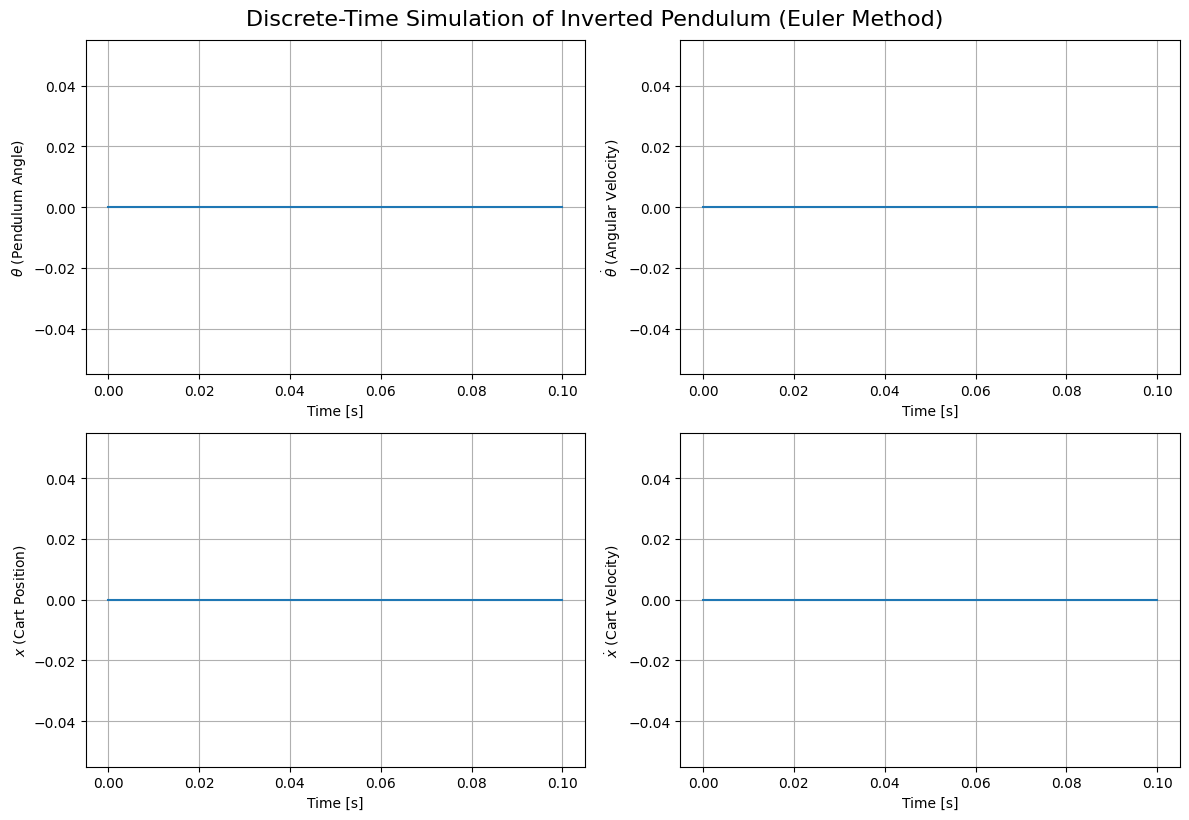

In [ ]:
# Time vector
time= np.arange(states.shape[0]) * dt

# Plotting
plt.figure(figsize=(12, 8))

labels= [r'$\theta$ (Pendulum Angle)', 
          r'$\dot{\theta}$ (Angular Velocity)', 
          r'$x$ (Cart Position)', 
          r'$\dot{x}$ (Cart Velocity)']

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(time, states[ : , i])
    plt.xlabel('Time [s]')
    plt.ylabel(labels[i])
    plt.grid(True)

plt.tight_layout()
plt.suptitle('"Discrete-Time Simulation of Inverted Pendulum (Euler Method)"', fontsize= 16, y= 1.02)
plt.show()

# Making the noisy dataset

Initialization

In [7]:
# Random seed for reproducibility
np.random.seed(48)

# Constants
T= 10.0  # total simulation time in seconds
dt= 0.001
N= int(T / dt) + 1  # number of time steps

# Initial state from uniform distribution
x0= np.random.uniform(-0.1, 0.1, size= 4)

# Process and measurement noise covariance
Q= np.array([
    [15.0, 0, 0, 0],
    [0, 9.6, 0, 0],
    [0, 0, 10.0, 0],
    [0, 0, 0, 17.0]
])
R= np.array([
    [19.2, 0],
    [0, 16.8]
])

# Prameters setup for simulation
u= 0.0

# Warning!

You can skip cells below till the next seperate line if you already have the "pendulum_noisy_data.xlsx" file.

----

Simulation

In [8]:
# Simulate with process and measurement noise
states= np.zeros((N, 4))
measurements= np.zeros((N, 2))
x= x0.copy()

for t in range(N):
    # Save state
    states[t]= x
    # Generate measurement (y1 = x1, y2 = x3)
    y= np.array([x[0], x[2]]) + np.random.multivariate_normal(np.zeros(2), R)
    measurements[t]= y
    # Apply dynamics + process noise
    x= discrete_step(x, u, dt) + np.random.multivariate_normal(np.zeros(4), Q)

# Simulation
df_states= pd.DataFrame(states, columns=['x1', 'x2', 'x3', 'x4'])
df_measurements= pd.DataFrame(measurements, columns= ['y1', 'y2'])
df= pd.concat([df_states, df_measurements], axis= 1)
df.head()

,x1,x2,x3,x4,y1,y2
0,-0.096502,0.078315,-0.043028,-0.040205,-2.892411,4.308191
1,4.139569,2.247808,-6.604332,-0.689180,11.477467,-8.232918
2,0.269992,-3.971172,-8.373199,8.891932,-1.333998,-13.522470
3,2.571565,1.751338,-3.434971,17.306869,-2.288290,-9.727630
4,-0.948620,0.314196,-2.214273,24.142718,-0.488177,-3.967612


In [9]:
# Saving to Excel
df.to_excel('pendulum_noisy_data.xlsx', index= False)

Visualization

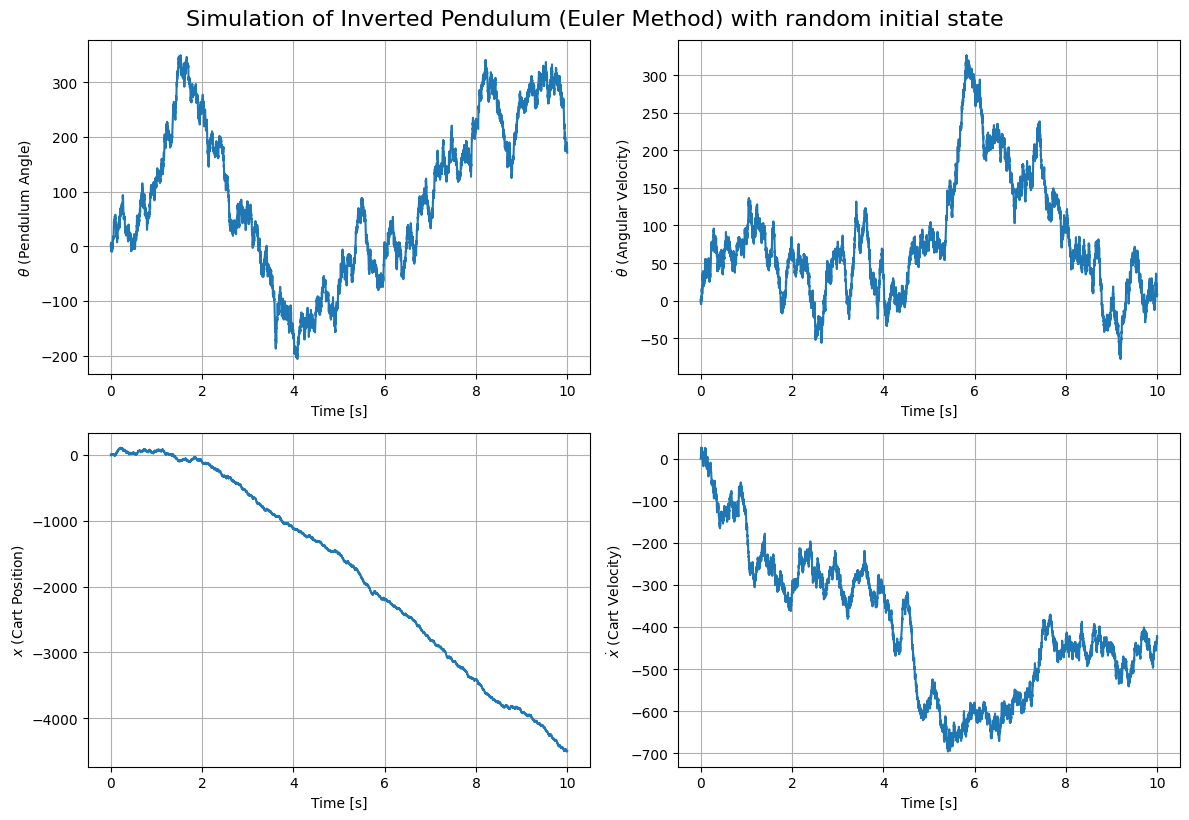

In [ ]:
# Time vector
time= np.arange(states.shape[0]) * dt

# Plotting
plt.figure(figsize=(12, 8))

labels= [r'$\theta$ (Pendulum Angle)', 
          r'$\dot{\theta}$ (Angular Velocity)', 
          r'$x$ (Cart Position)', 
          r'$\dot{x}$ (Cart Velocity)']

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(time, states[ : , i])
    plt.xlabel('Time [s]')
    plt.ylabel(labels[i])
    plt.grid(True)

plt.tight_layout()
plt.suptitle('"Simulation of Inverted Pendulum (Euler Method) with random initial state"', fontsize= 16, y= 1.02)
plt.show()

----

# EKF & UKF & PF

Loading the data

In [8]:
# Load data
data= pd.read_excel('pendulum_noisy_data.xlsx')

# Extract true states and measurements
X_true= data[['x1', 'x2', 'x3', 'x4']].values
Y_meas= data[['y1', 'y2']].values

In [9]:
# Constants
dt= 0.001
steps= X_true.shape[0]

# EKF

Manual implementation

Initialization

In [10]:
# --- System dynamics (as before) ---
def f(x, u= 0):
    return discrete_step(x, u, dt)

# --- Measurement model ---
def h(x):
    return np.array([x[0], x[2]])

# --- Jacobians using finite difference ---
def jacobian_f(x, eps= 1e-5):
    n= len(x)
    F= np.zeros((n, n))
    fx= f(x)
    for i in range(n):
        dx= np.zeros(n)
        dx[i] = eps
        F[:, i]= (f(x + dx) - fx) / eps
    return F

def jacobian_h(x):
    H= np.zeros((2, 4))
    H[0, 0]= 1
    H[1, 2]= 1
    return H

# Initial state guess and covariance
x_est= np.zeros(4)
P= np.eye(4) * 1.0

# Noise covariances
Q_ekf= Q
R_ekf= R

EKF loop

In [11]:
# Store results
X_ekf= np.zeros_like(X_true)

for k in range(steps):
    # Prediction
    F_k= jacobian_f(x_est)
    x_pred= f(x_est)
    P_pred= F_k @ P @ F_k.T + Q_ekf

    # Update
    H_k= jacobian_h(x_pred)
    y_pred= h(x_pred)
    y= Y_meas[k]
    S= H_k @ P_pred @ H_k.T + R_ekf
    K= P_pred @ H_k.T @ inv(S)

    x_est= x_pred + K @ (y - y_pred)
    P= (np.eye(4) - K @ H_k) @ P_pred

    # Store estimate
    X_ekf[k]= x_est

RMSE

In [12]:
rmse_ekf= np.sqrt(np.mean((X_true - X_ekf)**2, axis= 0))
print("EKF RMSE for each state:", rmse_ekf)

EKF RMSE for each state: [  3.35942272 115.22321828   3.00195536 137.09247471]


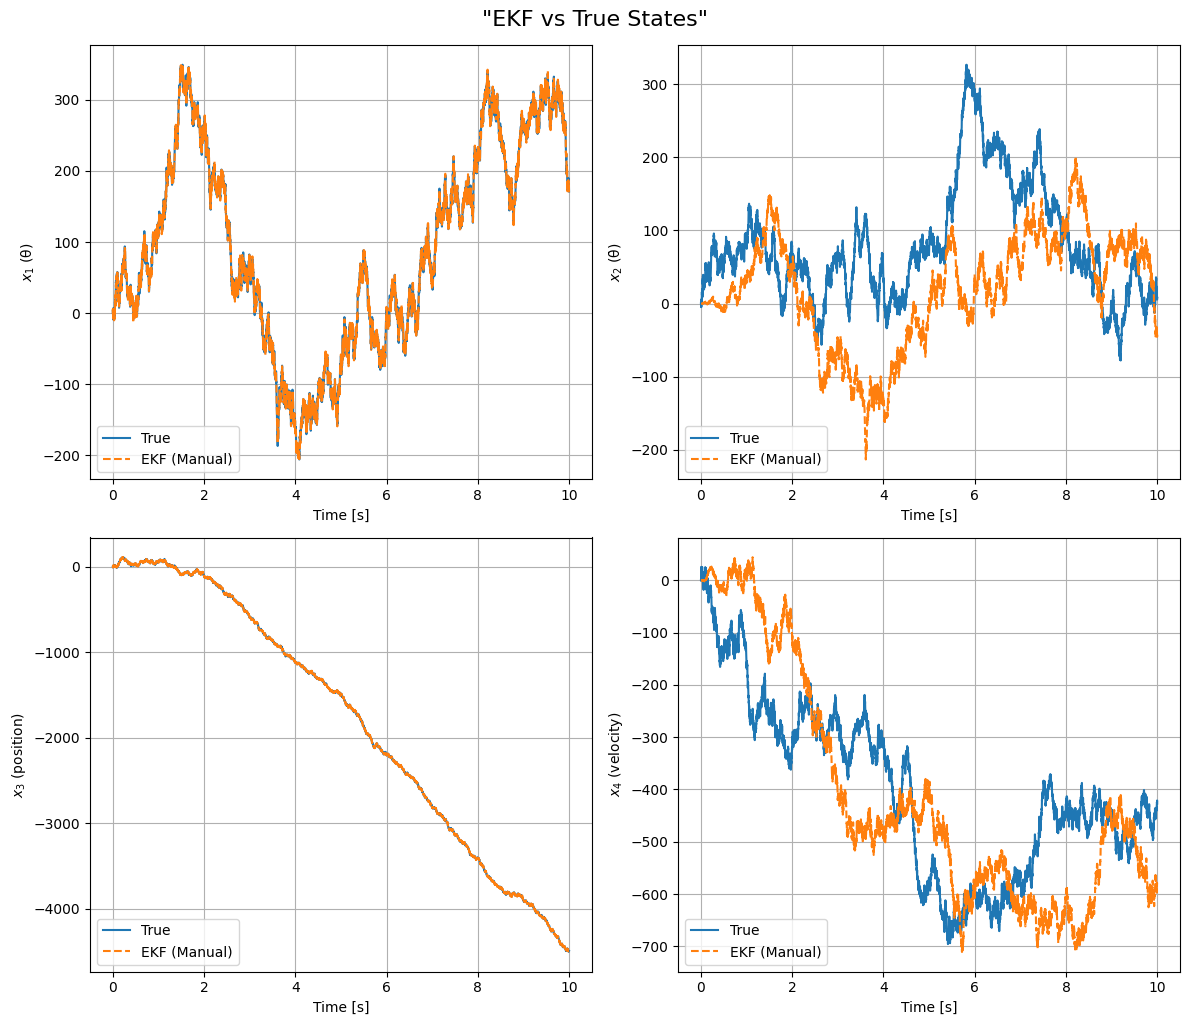

In [21]:
time= np.arange(steps) * dt
labels= [r'$x_1$ (θ)', r'$x_2$ (θ̇)', r'$x_3$ (position)', r'$x_4$ (velocity)']

plt.figure(figsize= (12, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(time, X_true[:, i], label= 'True', linewidth= 1.5)
    plt.plot(time, X_ekf[:, i], label= 'EKF (Manual)', linestyle= '--')
    plt.xlabel('Time [s]')
    plt.ylabel(labels[i])
    plt.grid(True)
    plt.legend(loc= 3)

plt.tight_layout()
plt.suptitle('"EKF vs True States"', fontsize= 16, y= 1.02)
plt.show()

EKF implementation using filterpy

RMSE for x1: 3.359284
RMSE for x2: 112.318365
RMSE for x3: 3.001982
RMSE for x4: 135.622126


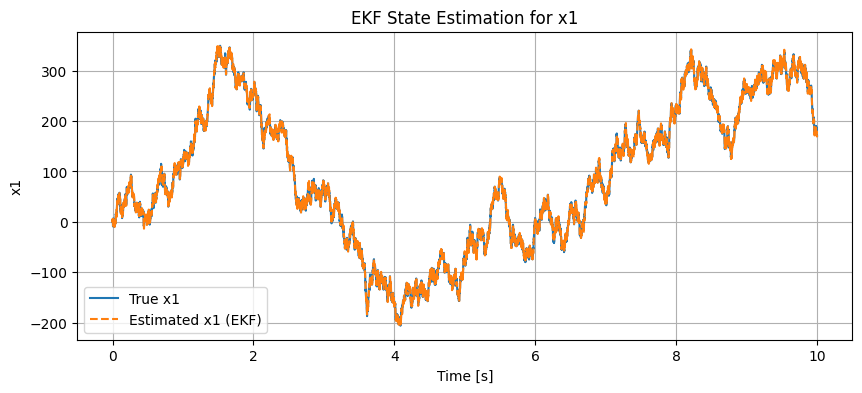

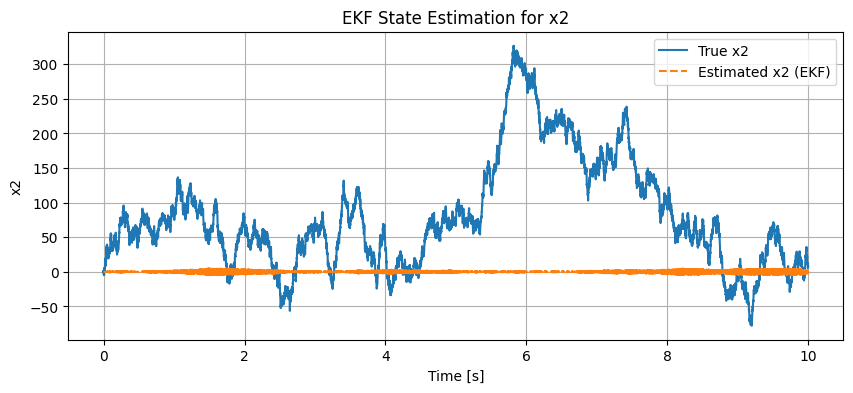

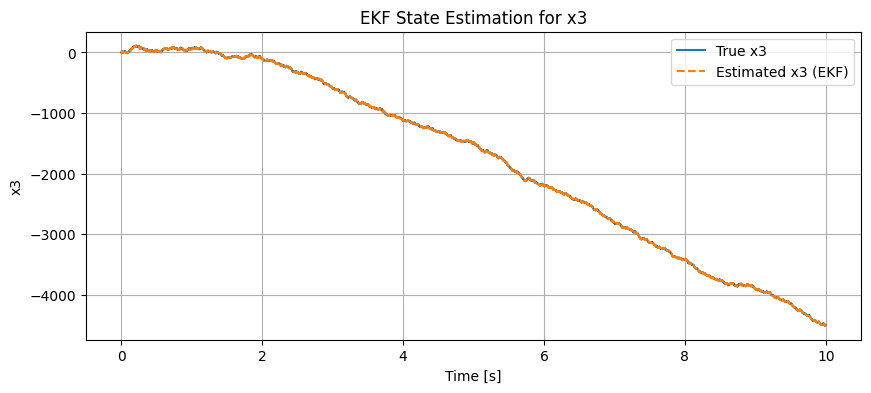

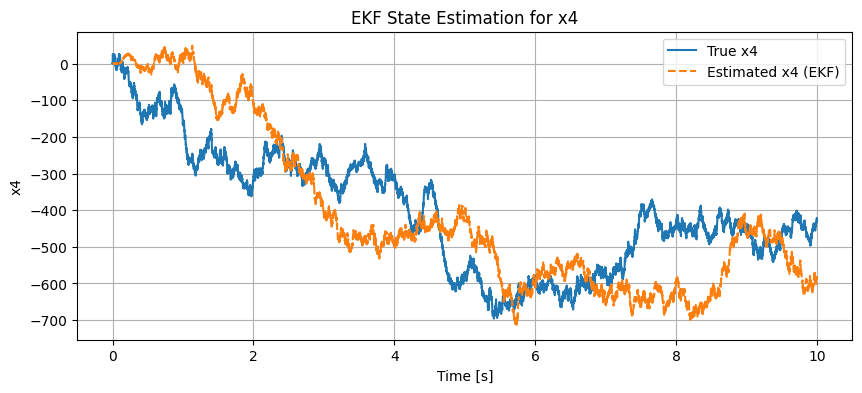

In [53]:
# --- Parameters ---
m= 0.1
M= 5
g= 9.81
l= 0.72
dt= 0.001

# --- Load Data ---
data= pd.read_excel('pendulum_noisy_data.xlsx')
true_states= data[['x1', 'x2', 'x3', 'x4']].values
measurements= data[['y1', 'y2']].values
N= true_states.shape[0]

# --- Define State Transition Function ---
def fx(x, dt):
    x1, x2, x3, x4= x

    dx1= x2
    dx2= (0 * np.cos(x1) - (M + m) * g * np.sin(x1) + m * l *(np.cos(x1) * np.sin(x1)) * x2**2) / (m * l * np.cos(x1)**2 - (M + m) * l)
    dx3= x4
    dx4= (0 + m * l * np.sin(x1) * x2**2 - m * g * np.cos(x1) * np.sin(x1)) / (M + m - m * np.cos(x1)**2)

    x1_new= x1 + dx1 * dt
    x2_new= x2 + dx2 * dt
    x3_new= x3 + dx3 * dt
    x4_new= x4 + dx4 * dt

    return np.array([x1_new, x2_new, x3_new, x4_new])

# --- Define Measurement Function ---
def hx(x):
    x1, x2, x3, x4= x
    return np.array([x1, x3])

# --- Jacobian of fx (F matrix) ---
def jacobian_F(x, dt):
    x1, x2, x3, x4= x

    # Partial derivatives manually derived:
    d_dx1= 1
    d_dx2= 0
    d_dx3= 1
    d_dx4= 0

    # More complicated terms
    denom2= (m * l * np.cos(x1)**2 - (M + m) * l)
    denom4 = (M + m - m * np.cos(x1)**2)

    dfdx1= ((M + m) * g * np.cos(x1) - m * l * (np.sin(x1)**2 - np.cos(x1)**2) * x2**2) / denom2 \
             - ((m * l * np.sin(2 * x1)) * ((0 * np.cos(x1) - (M + m) * g * np.sin(x1) + m * l * np.cos(x1) * np.sin(x1) * x2**2))) / denom2**2

    dfdx2= (2 * m * l * np.cos(x1) * np.sin(x1) * x2) / denom2

    dgdx1= (2 * m * g * np.sin(x1) * np.sin(x1) - m * g * np.cos(x1) * np.cos(x1) - m * l * x2**2 * np.cos(x1) * np.cos(x1) - m * l * x2**2 * np.sin(x1) * np.sin(x1)) / denom4 \
             - ((-2 * m * np.sin(x1) * np.cos(x1)) * (m * l * np.sin(x1) * x2**2 - m * g * np.cos(x1) * np.sin(x1))) / denom4**2

    dgdx2= (2 * m * l * np.sin(x1) * x2) / denom4

    F= np.eye(4)
    F[0,1]= dt
    F[1,0]= dfdx1 * dt
    F[1,1]= dfdx2 * dt
    F[2,3]= dt
    F[3,0]= dgdx1 * dt
    F[3,1]= dgdx2 * dt

    return F

# --- Jacobian of hx (H matrix) ---
def jacobian_H(x):
    # Measurement model y = [x1, x3]
    H= np.zeros((2, 4))
    H[0,0]= 1
    H[1,2]= 1
    return H

# --- EKF Setup ---
ekf= EKF(dim_x= 4, dim_z= 2)

ekf.x= np.random.uniform(-0.1, 0.1, size= 4)  # Initial guess

ekf.P= np.eye(4) * 0.1

ekf.Q= np.array([
    [15, 0, 0, 0],
    [0, 9.6, 0, 0],
    [0, 0, 10, 0],
    [0, 0, 0, 17]
])

ekf.R= np.array([
    [19.2, 0],
    [0, 16.8]
])

# --- Run EKF on all measurements ---
estimated_states= []

for z in measurements:
    F= jacobian_F(ekf.x, dt)
    ekf.F= F
    ekf.predict()
    ekf.update(z, HJacobian= lambda x: jacobian_H(x), Hx= hx)

    estimated_states.append(ekf.x.copy())


estimated_states= np.array(estimated_states)

# --- Calculate RMSE ---
rmse= np.sqrt(np.mean((true_states - estimated_states)**2, axis= 0))

for i, r in enumerate(rmse, 1):
    print(f'RMSE for x{i}: {r:.6f}')

# --- Plot Results ---
time= np.linspace(0, (N - 1) * dt, N)

state_labels= ['x1', 'x2', 'x3', 'x4']

for i in range(4):
    plt.figure(figsize= (10, 4))
    plt.plot(time, true_states[:, i], label= f'True {state_labels[i]}')
    plt.plot(time, estimated_states[:, i], '--', label= f'Estimated {state_labels[i]} (EKF)')
    plt.xlabel('Time [s]')
    plt.ylabel(state_labels[i])
    plt.legend()
    plt.grid()
    plt.title(f'EKF State Estimation for {state_labels[i]}')
    plt.show()

# UKF

UKF manually implementation

RMSE for x1: 3.360238
RMSE for x2: 114.358246
RMSE for x3: 3.037829
RMSE for x4: 133.679715


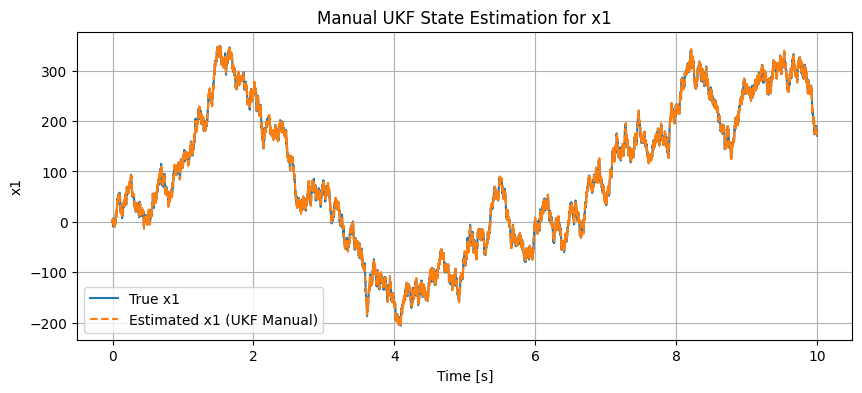

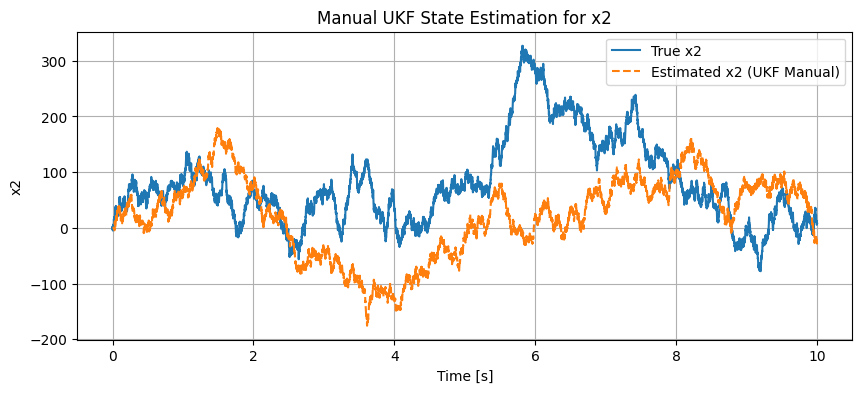

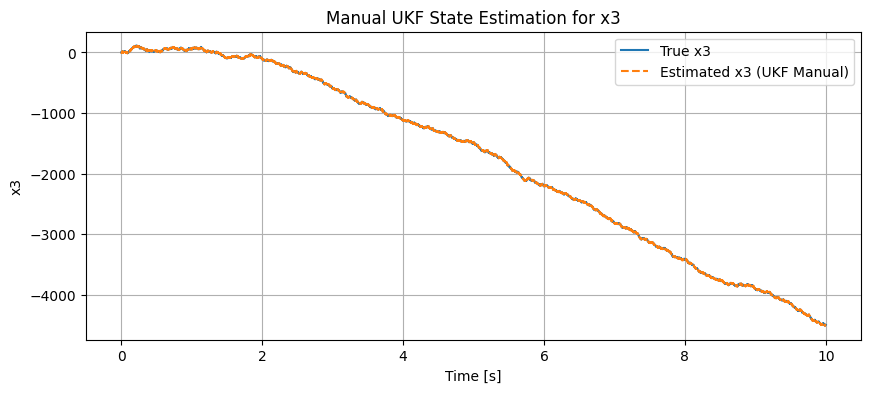

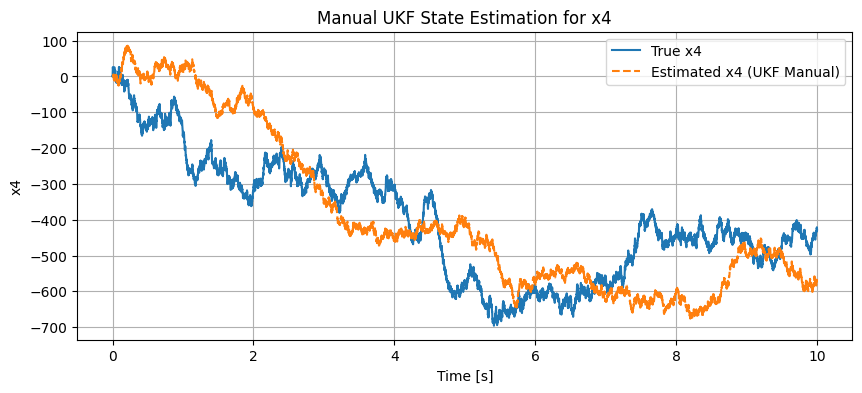

In [54]:
# --- Parameters ---
m= 0.1
M= 5
g= 9.81
l= 0.72
dt= 0.001

# UKF parameters
alpha= 1
kappa= 0
beta= 2

# Load data
data= pd.read_excel('pendulum_noisy_data.xlsx')
true_states= data[['x1', 'x2', 'x3', 'x4']].values
measurements= data[['y1', 'y2']].values
N= true_states.shape[0]

# State transition
def fx(x, dt):
    x1, x2, x3, x4= x

    dx1= x2
    dx2= (0 * np.cos(x1) - (M + m) * g * np.sin(x1) + m * l * (np.cos(x1) * np.sin(x1)) * x2**2) / (m * l * np.cos(x1)**2 - (M + m) * l)
    dx3= x4
    dx4= (0 + m * l * np.sin(x1) * x2**2 - m * g * np.cos(x1) * np.sin(x1)) / (M + m - m * np.cos(x1)**2)

    x1_new= x1 + dx1 * dt
    x2_new= x2 + dx2 * dt
    x3_new= x3 + dx3 * dt
    x4_new= x4 + dx4 * dt

    return np.array([x1_new, x2_new, x3_new, x4_new])

# Measurement function
def hx(x):
    return np.array([x[0], x[2]])

# Sigma point generation
def sigma_points(x, P, alpha, kappa):
    n= len(x)
    lambda_= alpha**2 * (n + kappa) - n
    sigma_pts= np.zeros((2 * n + 1, n))

    try:
        U= np.linalg.cholesky((n + lambda_) * P)
    except np.linalg.LinAlgError:
        U= np.linalg.cholesky((n + lambda_) * (P + 1e-6 * np.eye(n)))

    sigma_pts[0]= x
    for i in range(n):
        sigma_pts[i + 1]= x + U[i]
        sigma_pts[i + 1 + n]= x - U[i]
    return sigma_pts, lambda_

# Weights
def compute_weights(n, lambda_, alpha, beta):
    Wm= np.full(2 * n + 1, 1 / (2 * (n + lambda_)))
    Wc= np.full(2 * n + 1, 1 / (2 * (n + lambda_)))
    Wm[0]= lambda_ / (n + lambda_)
    Wc[0]= lambda_ / (n + lambda_) + (1 - alpha**2 + beta)
    return Wm, Wc

# Initialize
n= 4  # state dimension
m_dim= 2  # measurement dimension

x= np.random.uniform(-0.1, 0.1, size= n)
P= np.eye(n) * 0.1
Q= np.array([
    [15, 0, 0, 0],
    [0, 9.6, 0, 0],
    [0, 0, 10, 0],
    [0, 0, 0, 17]
])
R= np.array([
    [19.2, 0],
    [0, 16.8]
])

estimated_states= []

# UKF Loop
for z in measurements:
    # 1. Sigma Points
    chi, lambda_= sigma_points(x, P, alpha, kappa)
    Wm, Wc= compute_weights(n, lambda_, alpha, beta)

    # 2. Predict Sigma Points
    chi_pred= np.array([fx(sp, dt) for sp in chi])

    # 3. Predict Mean and Covariance
    x_pred= np.sum(Wm[:, None] * chi_pred, axis= 0)
    P_pred= Q.copy()
    for i in range(2*n+1):
        diff= chi_pred[i] - x_pred
        P_pred += Wc[i] * np.outer(diff, diff)

    # 4. Predict Measurements
    Z_sigma= np.array([hx(sp) for sp in chi_pred])
    z_pred= np.sum(Wm[:, None] * Z_sigma, axis= 0)
    Pz= R.copy()
    for i in range(2 * n + 1):
        diff= Z_sigma[i] - z_pred
        Pz += Wc[i] * np.outer(diff, diff)

    # 5. Cross Covariance
    Pxz= np.zeros((n, m_dim))
    for i in range(2 * n + 1):
        Pxz += Wc[i] * np.outer(chi_pred[i] - x_pred, Z_sigma[i] - z_pred)

    # 6. Kalman Gain
    K= Pxz @ np.linalg.inv(Pz)

    # 7. Update
    x= x_pred + K @ (z - z_pred)
    P= P_pred - K @ Pz @ K.T

    estimated_states.append(x.copy())

estimated_states= np.array(estimated_states)

# Calculate RMSE
rmse= np.sqrt(np.mean((true_states - estimated_states)**2, axis= 0))
for i, r in enumerate(rmse, 1):
    print(f'RMSE for x{i}: {r:.6f}')

# Plot
time= np.linspace(0, (N - 1) * dt, N)
state_labels= ['x1', 'x2', 'x3', 'x4']

for i in range(4):
    plt.figure(figsize= (10,4))
    plt.plot(time, true_states[:,i], label= f'True {state_labels[i]}')
    plt.plot(time, estimated_states[:,i], '--', label= f'Estimated {state_labels[i]} (UKF Manual)')
    plt.xlabel('Time [s]')
    plt.ylabel(state_labels[i])
    plt.legend()
    plt.grid()
    plt.title(f'Manual UKF State Estimation for {state_labels[i]}')
    plt.show()

UKF implementation using filterpy

RMSE for x1: 3.359817
RMSE for x2: 118.517025
RMSE for x3: 3.001032
RMSE for x4: 143.156537


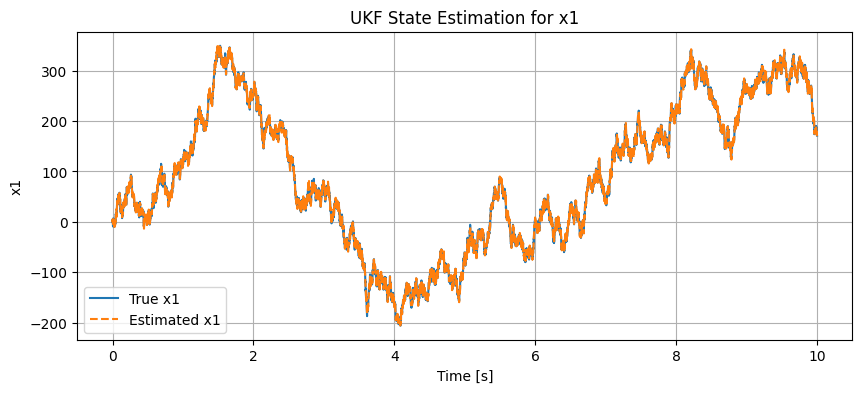

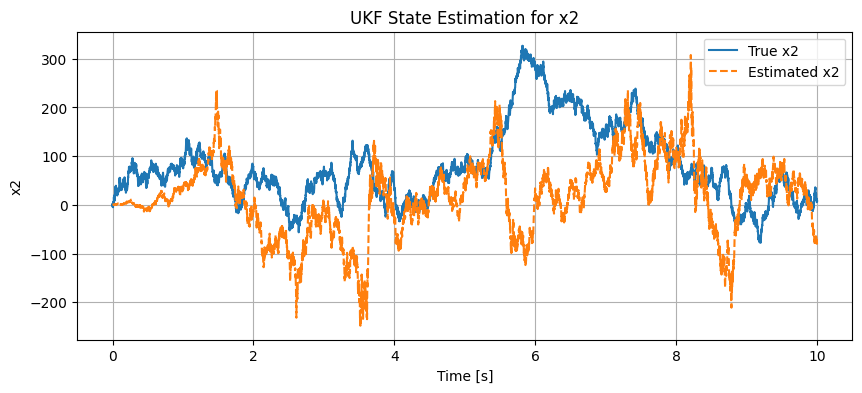

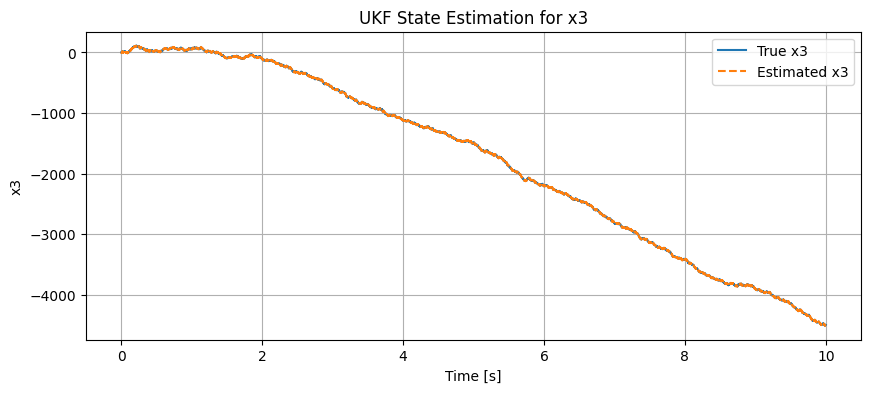

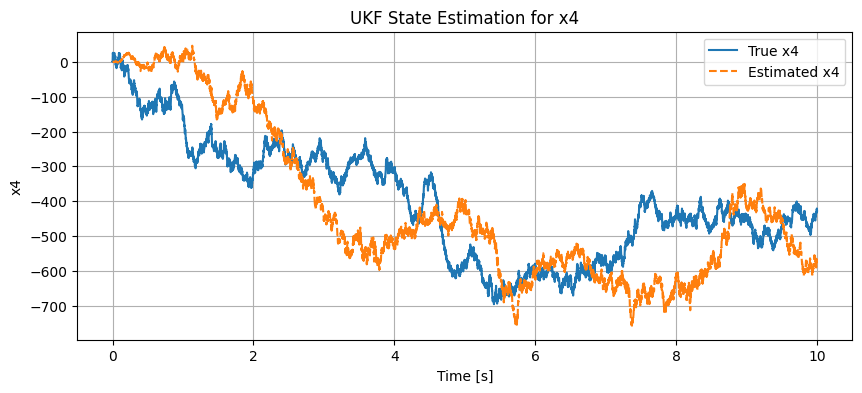

In [55]:
# --- Parameters ---
m= 0.1  # mass of pendulum
M= 5    # mass of cart
g= 9.81 # gravity
l= 0.72 # pendulum length
dt= 0.001  # Sampling time

# --- Load Data ---
# Assuming you have saved your data into a CSV or Excel file
data= pd.read_excel('pendulum_noisy_data.xlsx')
true_states= data[['x1', 'x2', 'x3', 'x4']].values
measurements= data[['y1', 'y2']].values

N= true_states.shape[0]  # number of time steps

# --- Define State Transition Function (Discrete-time dynamics) ---
def fx(x, dt):
    x1, x2, x3, x4= x

    # Continuous-time dynamics
    dx1= x2
    dx2= (0 * np.cos(x1) - (M + m) * g * np.sin(x1) + m * l * (np.cos(x1) * np.sin(x1)) * x2**2) / (m * l * np.cos(x1)**2 - (M + m) * l)
    dx3= x4
    dx4= (0 + m * l * np.sin(x1) * x2**2 - m * g * np.cos(x1) * np.sin(x1)) / (M + m - m * np.cos(x1)**2)

    # Euler discretization
    x1_new= x1 + dx1 * dt
    x2_new= x2 + dx2 * dt
    x3_new= x3 + dx3 * dt
    x4_new= x4 + dx4 * dt

    return np.array([x1_new, x2_new, x3_new, x4_new])

# --- Define Measurement Function ---
def hx(x):
    x1, x2, x3, x4= x
    return np.array([x1, x3])

# --- UKF Setup ---
points= MerweScaledSigmaPoints(n= 4, alpha= 0.1, beta= 2., kappa= 0)

ukf= UKF(dim_x= 4, dim_z= 2, fx= fx, hx= hx, dt= dt, points= points)

# Initial guess
ukf.x= np.random.uniform(-0.1, 0.1, size= 4)

# Covariances
ukf.P= np.eye(4) * 0.1  # initial estimation covariance

ukf.Q= np.array([
    [15, 0, 0, 0],
    [0, 9.6, 0, 0],
    [0, 0, 10, 0],
    [0, 0, 0, 17]
])

ukf.R= np.array([
    [19.2, 0],
    [0, 16.8]
])

# --- Run UKF on all measurements ---
estimated_states= []

for z in measurements:
    ukf.predict()
    ukf.update(z)
    estimated_states.append(ukf.x.copy())

estimated_states= np.array(estimated_states)

# --- Calculate RMSE for each state ---
rmse= np.sqrt(np.mean((true_states - estimated_states)**2, axis= 0))

for i, r in enumerate(rmse, 1):
    print(f'RMSE for x{i}: {r:.6f}')

# --- Plot Results ---
time= np.linspace(0, (N - 1) * dt, N)

state_labels= ['x1', 'x2', 'x3', 'x4']

for i in range(4):
    plt.figure(figsize= (10, 4))
    plt.plot(time, true_states[:, i], label= f'True {state_labels[i]}')
    plt.plot(time, estimated_states[:, i], '--', label= f'Estimated {state_labels[i]}')
    plt.xlabel('Time [s]')
    plt.ylabel(state_labels[i])
    plt.legend()
    plt.grid()
    plt.title(f'UKF State Estimation for {state_labels[i]}')
    plt.show()

# Particle Filter

a simple example

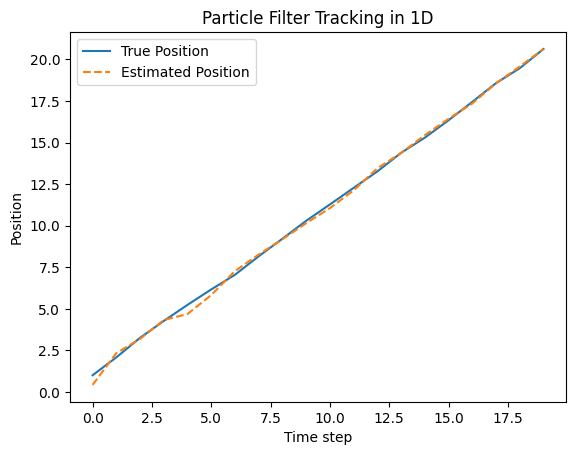

In [56]:
# Parameters
true_pos= 0.0
velocity= 1.0
motion_noise_std= 0.1
measurement_noise_std= 1.0
N_particles= 1000
particles= np.random.uniform(-10, 10, size= N_particles)
weights= np.ones(N_particles) / N_particles

def motion_model(x):
    return x + velocity + np.random.normal(0, motion_noise_std)

def measurement_model(x):
    return x + np.random.normal(0, measurement_noise_std)

def measurement_prob(z, x):
    return (1.0 / np.sqrt(2 * np.pi * measurement_noise_std**2)) * \
           np.exp(- (z - x)**2 / (2 * measurement_noise_std**2))

n_steps= 20
true_positions= []
estimated_positions= []

for t in range(n_steps):
    true_pos= motion_model(true_pos)
    true_positions.append(true_pos)
    
    z= measurement_model(true_pos)
    
    particles= motion_model(particles)
    
    weights= measurement_prob(z, particles)
    weights += 1.e-300
    weights /= np.sum(weights)
    
    estimated_pos= np.sum(particles * weights)
    estimated_positions.append(estimated_pos)
    
    indices= np.random.choice(range(N_particles), size= N_particles, p= weights)
    particles= particles[indices]
    weights= np.ones(N_particles) / N_particles

plt.plot(true_positions, label= "True Position")
plt.plot(estimated_positions, label= "Estimated Position", linestyle= '--')
plt.xlabel('Time step')
plt.ylabel('Position')
plt.legend()
plt.title('Particle Filter Tracking in 1D')
plt.show()